In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility

pd.options.mode.chained_assignment = None  #hide any pandas warnings

#Import libraries for plotting confusion metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

#Import libraries for hyperparameter tuning
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

%matplotlib inline





In [2]:
def random_forest(dt,target,depth = None, estimators = 100):
    X= dt.drop(target, 1)
    y = dt[target] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=10) #split the data
    model = RandomForestClassifier(max_depth = depth,n_estimators = estimators)
    model.fit(X_train, y_train)
    # Use score method to get accuracy of model
    score = model.score(X_test, y_test)
    print(score)
    
    #Get the prediction results
    y_predict = model.predict(X_test)
    y_pred_quant = model.predict_proba(X_test)[:, 1]
    y_pred_bin = model.predict(X_test)

    #Show the confusion matrix
    #Create the confusion matrics
    cm = metrics.confusion_matrix(y_test, y_pred_bin)
    
    feature_list = [i for i in X_train.columns]
    
    #Determine the feature importances
    # Get numerical feature importances
    importances = list(model.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    #Extract the tree
    tree = model.estimators_[5]
    
    return score,cm,tree,importances,y_predict,y_pred_quant,y_pred_bin,X_train, X_test, y_train, y_test

In [25]:
#Read the data file and drop garbage columns
dt = pd.read_csv('cardiotocography.csv')
dt = dt.drop(['Unnamed: 23','CLASS'],axis = 1)
summary = dt.describe()
type(summary)
#print(summary.columns)
#print(summary.index)
summary = summary.transpose()
#print(summary.columns)
from tabulate import tabulate
sum = summary[['count','mean','std']]
print(tabulate(sum,headers =['features','count','mean','std'] ))

features      count           mean           std
----------  -------  -------------  ------------
LB             2126  133.304         9.84084
AC             2126    0.00317827    0.00386559
FM             2126    0.00948071    0.0466658
UC             2126    0.00436642    0.00294607
DL             2126    0.00188946    0.00296021
DS             2126    3.29257e-06   5.72998e-05
DP             2126    0.000158514   0.000589948
ASTV           2126   46.9901       17.1928
MSTV           2126    1.33278       0.883241
ALTV           2126    9.84666      18.3969
MLTV           2126    8.18763       5.62825
Width          2126   70.4459       38.9557
Min            2126   93.5795       29.5602
Max            2126  164.025        17.9442
Nmax           2126    4.0682        2.94939
Nzeros         2126    0.323612      0.706059
Mode           2126  137.452        16.3813
Mean           2126  134.611        15.5936
Median         2126  138.09         14.4666
Variance       2126   18.8081     

In [4]:
#detect and remove the variables with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold= 0.1)
sel.fit(dt)
vars = sel.get_support()
vars
#sel.get_params()


array([ True, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [5]:
#Determine the value distribution of each column to find out categorical variables
for i in range(len(dt.columns)):
    print(dt.iloc[:,i].value_counts())

133    136
130    111
122    109
138    103
125     91
128     85
120     78
144     77
142     77
132     76
136     72
140     70
134     67
135     65
146     62
127     60
137     59
129     57
123     56
131     56
143     56
148     52
121     44
139     39
141     39
126     38
145     37
115     28
150     26
110     21
149     18
152     17
119     17
112     16
147     14
151     14
159     12
114     11
158     10
124     10
118      9
154      8
106      7
116      5
157      4
156      4
117      2
160      1
Name: LB, dtype: int64
0.000    894
0.003    161
0.002    160
0.001    143
0.004    117
0.006    112
0.005    110
0.008    103
0.007     91
0.009     60
0.010     50
0.011     36
0.012     24
0.013     22
0.014     20
0.015      9
0.016      7
0.017      4
0.018      2
0.019      1
Name: AC, dtype: int64
0.000    1311
0.001     164
0.002     112
0.003      88
0.004      49
0.005      36
0.006      31
0.007      28
0.010      25
0.009      25
0.008      25
0.013      1

In [6]:
dt['Tendency'][dt['Tendency'] == -1] = 'left_asymmetric'
dt['Tendency'][dt['Tendency'] == 0] = 'symmetric'
dt['Tendency'][dt['Tendency'] == 1] = 'right_asymmetric'

dt['Tendency'] = dt['Tendency'].astype('object')

dt = pd.get_dummies(dt, drop_first=False)
dt.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Nmax,Nzeros,Mode,Mean,Median,Variance,NSP,Tendency_left_asymmetric,Tendency_right_asymmetric,Tendency_symmetric
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,2,0,120,137,121,73,2,0,1,0
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,6,1,141,136,140,12,1,0,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,5,1,141,135,138,13,1,0,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,11,0,137,134,137,13,1,0,1,0
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,9,0,137,136,138,11,1,0,1,0


In [7]:
#Count the values of target variable classes
dt.NSP.value_counts()

1    1655
2     295
3     176
Name: NSP, dtype: int64

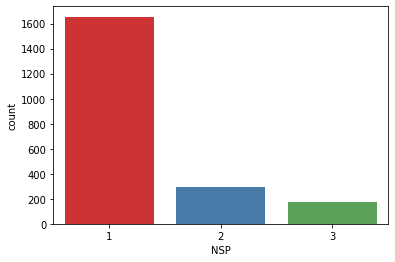

In [8]:
sns.countplot(x="NSP", data=dt, palette="Set1")
plt.show()

In [9]:
X= dt.drop('NSP', 1)
y = dt['NSP'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=10) #split the data

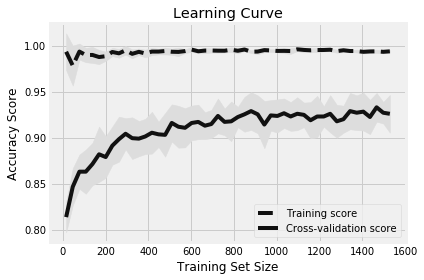

In [31]:
#plotting the learning curve
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

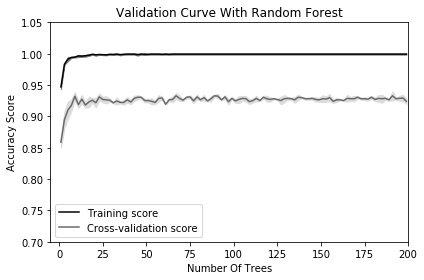

In [10]:
#Hyperparameter tuning : validation curve for number of trees

# Create range of values for parameter
param_range = np.arange(1, 200, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.xlim([-5,200])
plt.ylim([0.7,1.05])
plt.tight_layout()
plt.legend(loc="best")
plt.show()

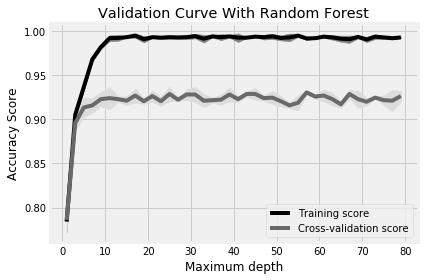

In [32]:
#Hyperparameter tuning : validation curve for maximum depth of trees

# Create range of values for parameter
param_range = np.arange(1, 80, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="max_depth", 
                                             param_range=param_range,
                                             cv=3, 
                                             scoring="accuracy", 
                                             n_jobs=-1)


# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Maximum depth")
plt.ylabel("Accuracy Score")
#plt.xlim([-5,100])
#plt.ylim([0.7,1.05])
plt.tight_layout()
plt.legend(loc="best")
plt.show()

In [33]:
model = RandomForestClassifier(max_depth = 10, n_estimators = 20)
model.fit(X_train, y_train)
#model.pvalues

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
#Make predictions
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

0.9483568075117371
The precision recall, F1 score and support for each class
              precision    recall  f1-score   support

           1      0.970     0.970     0.970       336
           2      0.847     0.820     0.833        61
           3      0.903     0.966     0.933        29

    accuracy                          0.948       426
   macro avg      0.907     0.918     0.912       426
weighted avg      0.948     0.948     0.948       426



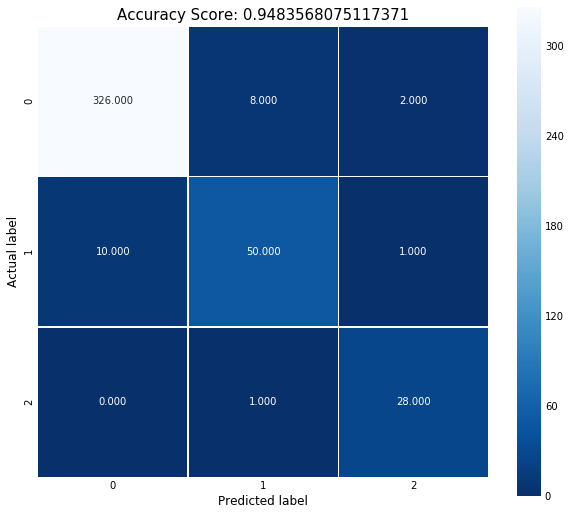

In [35]:
# Use score method to get accuracy of model
score = model.score(X_test, y_test)
print(score)

print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))
#Show the confusion matrix


#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [15]:
#Feature selection using wrapping method
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
#Fit the model
lr.fit(X_train, y_train)
coef1 = lr.coef_
print(np.mean(abs(coef1)))
print(abs(coef1[1,:]))

0.05018159595292766
[5.28960273e-02 1.53009583e-03 3.34486088e-03 1.01529270e-03
 2.46084266e-04 4.03047988e-07 6.32482733e-05 4.12982117e-02
 2.05141152e-01 2.36344401e-02 3.66576031e-02 1.68384209e-02
 7.53775324e-03 2.43761742e-02 2.12804877e-01 5.15722349e-02
 4.80665351e-03 4.00711493e-02 1.08768435e-02 7.04137101e-04
 1.59834984e-02 4.83963352e-03 4.17246716e-02]


In [16]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000))
sel.fit(X_train, y_train)
feat = sel.get_support()
selected_feat= X_train.columns[(feat)]
print(len(selected_feat))
print(selected_feat)


9
Index(['AC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Mode', 'Mean', 'Median'], dtype='object')


In [17]:
sellr = SelectFromModel(estimator=LogisticRegression()).fit(X_train, y_train)
f = sellr.get_support()
sf= X_train.columns[(f)]
print(sf)


Index(['FM', 'MSTV', 'Tendency_left_asymmetric', 'Tendency_right_asymmetric',
       'Tendency_symmetric'],
      dtype='object')


In [18]:
lrselected = dt[['FM', 'MSTV','Tendency_left_asymmetric', 'Tendency_right_asymmetric',
       'Tendency_symmetric','NSP']]
lrselected.head()

,FM,MSTV,Tendency_left_asymmetric,Tendency_right_asymmetric,Tendency_symmetric,NSP
0,0.0,0.5,0,1,0,2
1,0.0,2.1,0,0,1,1
2,0.0,2.1,0,0,1,1
3,0.0,2.4,0,1,0,1
4,0.0,2.4,0,1,0,1


In [19]:
selected = dt[['DP', 'ASTV', 'MSTV', 'ALTV', 'Mode', 'Mean', 'Median','NSP']]
selected.head()

,DP,ASTV,MSTV,ALTV,Mode,Mean,Median,NSP
0,0.0,73,0.5,43,120,137,121,2
1,0.0,17,2.1,0,141,136,140,1
2,0.0,16,2.1,0,141,135,138,1
3,0.0,16,2.4,0,137,134,137,1
4,0.0,16,2.4,0,137,136,138,1


In [20]:
selected2 = dt[['AC', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Mode', 'Mean', 'Median','NSP']]
selected2.head()

,AC,DP,ASTV,MSTV,ALTV,MLTV,Mode,Mean,Median,NSP
0,0.000,0.0,73,0.5,43,2.4,120,137,121,2
1,0.006,0.0,17,2.1,0,10.4,141,136,140,1
2,0.003,0.0,16,2.1,0,13.4,141,135,138,1
3,0.003,0.0,16,2.4,0,23.0,137,134,137,1
4,0.007,0.0,16,2.4,0,19.9,137,136,138,1


Accuracy and variable importance
0.9577464788732394
Variable: ASTV                 Importance: 0.21
Variable: ALTV                 Importance: 0.2
Variable: MSTV                 Importance: 0.18
Variable: Mean                 Importance: 0.16
Variable: Mode                 Importance: 0.1
Variable: Median               Importance: 0.09
Variable: DP                   Importance: 0.07
The precision recall, F1 score and support for each class
              precision    recall  f1-score   support

           1      0.965     0.985     0.975       336
           2      0.942     0.803     0.867        61
           3      0.903     0.966     0.933        29

    accuracy                          0.958       426
   macro avg      0.937     0.918     0.925       426
weighted avg      0.958     0.958     0.957       426



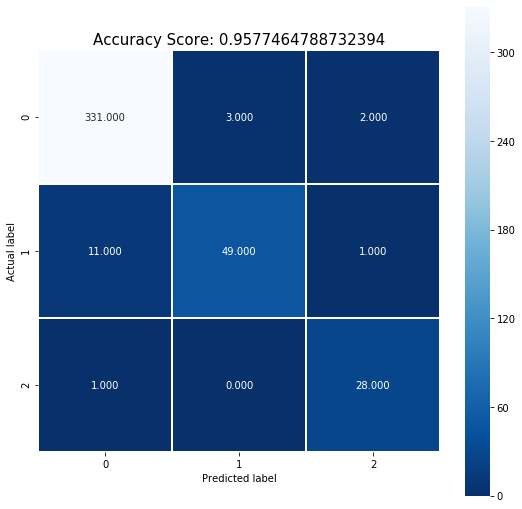

In [21]:
#Build model using the features from feature selection using randomforestclassifier
print("Accuracy and variable importance")
sc,cm,tree,imp,y_predict,y_pred_quant,y_pred_bin,X_train, X_test, y_train, y_test = random_forest(selected,'NSP',depth = 10, estimators = 1000)


#Create the confusion matrics

cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(sc)
plt.title(all_sample_title, size = 15);

# Print the precision and recall, among other metrics
print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))

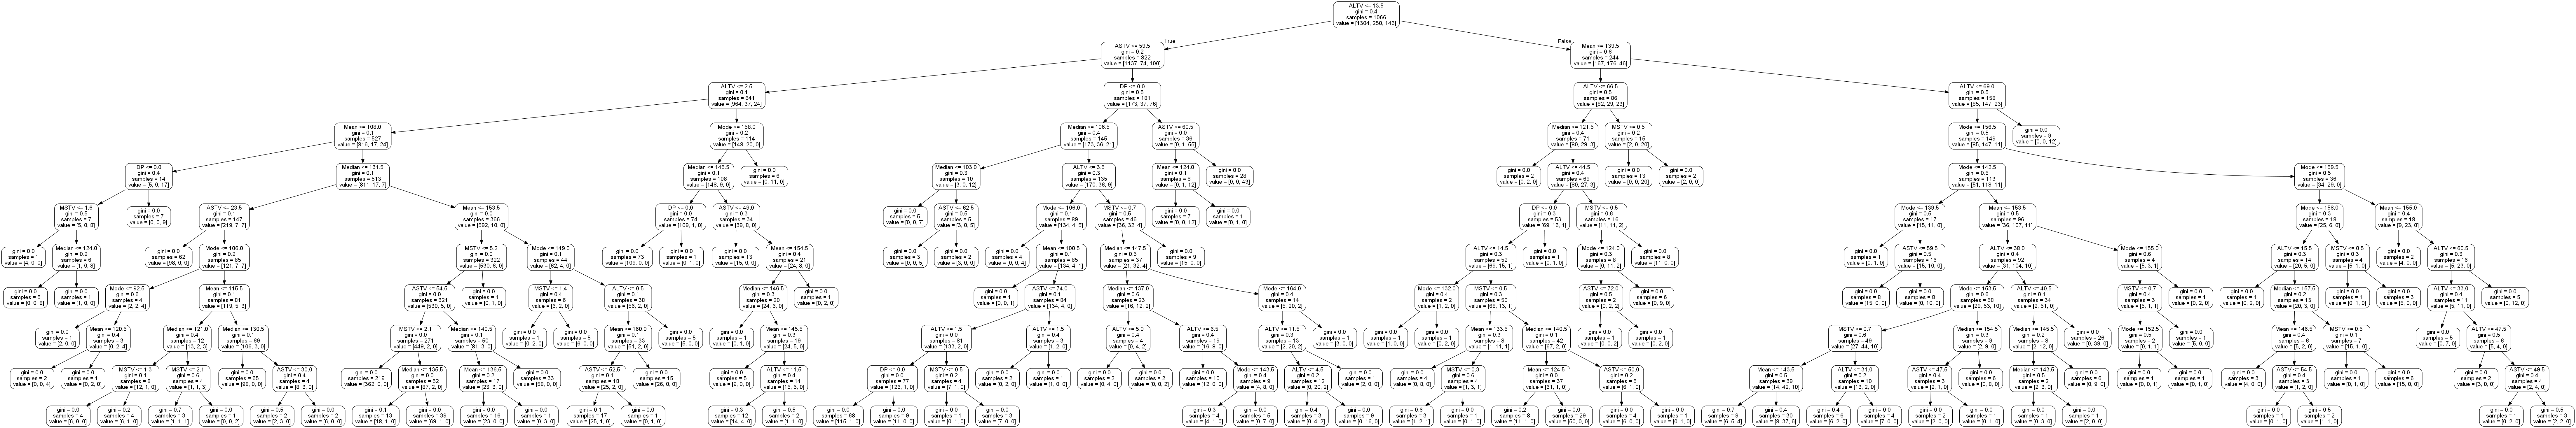

In [22]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# extract the feature names
sele = selected.drop(['NSP'], axis = 1)
feature_names = [i for i in sele.columns]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

from IPython.display import Image 
Image(filename = 'tree.png')

0.9577464788732394
Variable: ASTV                 Importance: 0.14
Variable: MSTV                 Importance: 0.11
Variable: ALTV                 Importance: 0.11
Variable: Mean                 Importance: 0.1
Variable: Mode                 Importance: 0.06
Variable: Median               Importance: 0.06
Variable: AC                   Importance: 0.05
Variable: DP                   Importance: 0.05
Variable: LB                   Importance: 0.04
Variable: UC                   Importance: 0.04
Variable: MLTV                 Importance: 0.04
Variable: Width                Importance: 0.04
Variable: Min                  Importance: 0.04
Variable: Variance             Importance: 0.04
Variable: Max                  Importance: 0.03
Variable: FM                   Importance: 0.02
Variable: Nmax                 Importance: 0.02
Variable: DL                   Importance: 0.01
Variable: DS                   Importance: 0.0
Variable: Nzeros               Importance: 0.0
Variable: Tendency_left_

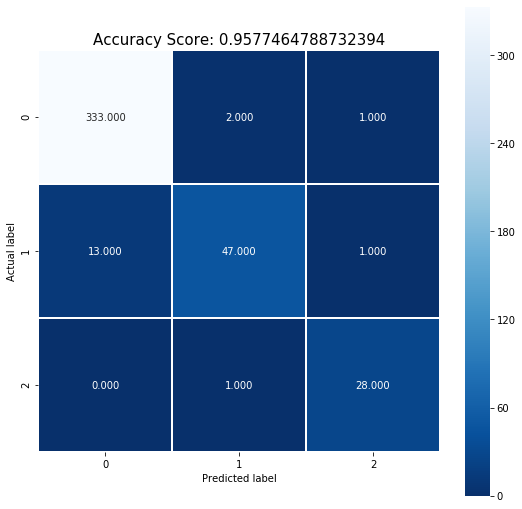

In [23]:
sc,cm,tree,imp,y_predict,y_pred_quant,y_pred_bin,X_train, X_test, y_train, y_test = random_forest(dt,'NSP',depth = 10, estimators = 1000)
#print(sc)
#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(sc)
plt.title(all_sample_title, size = 15);

# Print the precision and recall, among other metrics
print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))

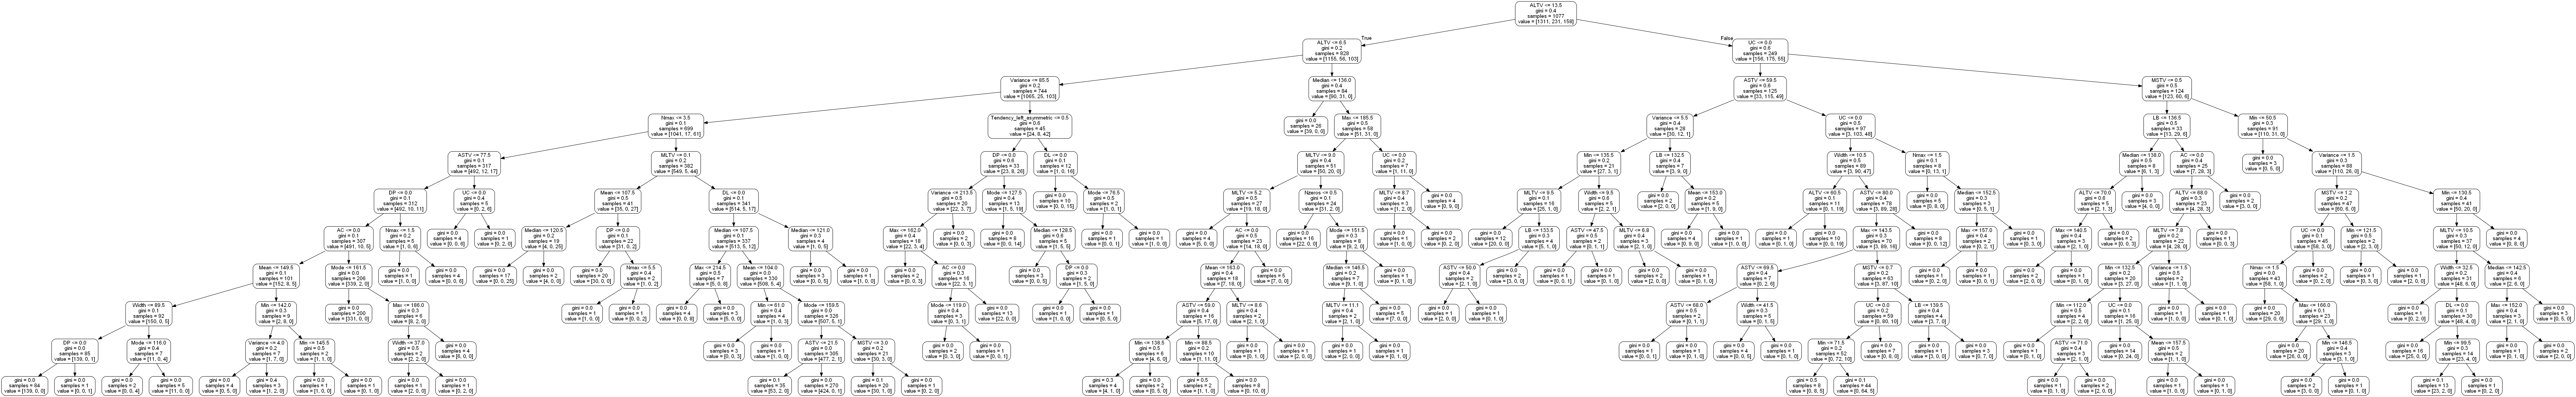

In [24]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# extract the feature names
sele = dt.drop(['NSP'], axis = 1)
feature_names = [i for i in sele.columns]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

from IPython.display import Image 
Image(filename = 'tree.png')

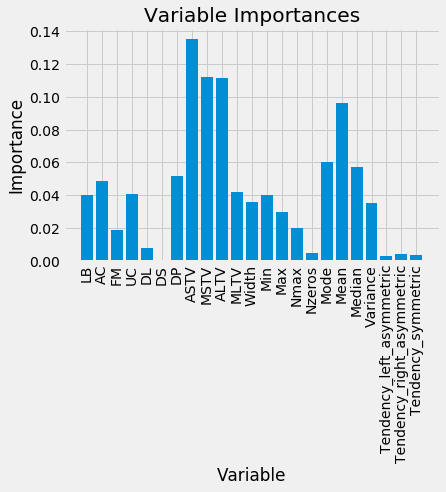

In [25]:
#Draw a bar plot of variable importances
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(imp)))
# Make a bar chart
plt.bar(x_values, imp, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

0.9553990610328639
Variable: Mean                 Importance: 0.29
Variable: ASTV                 Importance: 0.27
Variable: MSTV                 Importance: 0.22
Variable: ALTV                 Importance: 0.22
The precision recall, F1 score and support for each class
              precision    recall  f1-score   support

           1      0.962     0.985     0.974       336
           2      0.942     0.803     0.867        61
           3      0.900     0.931     0.915        29

    accuracy                          0.955       426
   macro avg      0.935     0.906     0.919       426
weighted avg      0.955     0.955     0.954       426



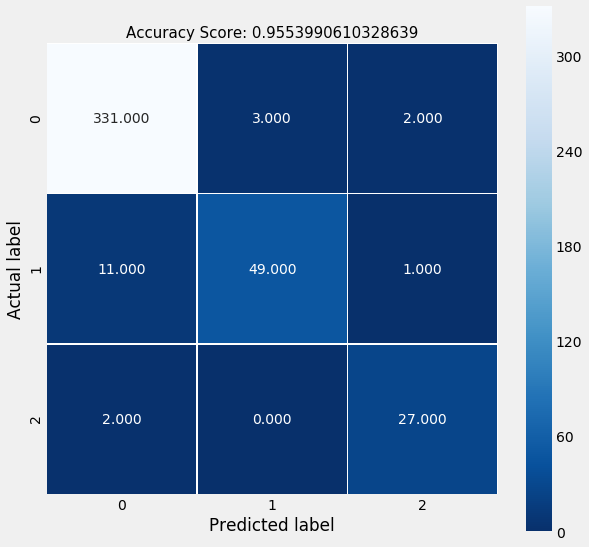

In [26]:
#Build a model with four most important variables
selected3 = dt[[ 'ASTV', 'MSTV', 'ALTV', 'Mean', 'NSP']]
sc,cm,tree,imp,y_predict,y_pred_quant,y_pred_bin,X_train, X_test, y_train, y_test = random_forest(selected3,'NSP',depth = 10, estimators = 1000)
#print(sc)
#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(sc)
plt.title(all_sample_title, size = 15);
# Print the precision and recall, among other metrics
print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))

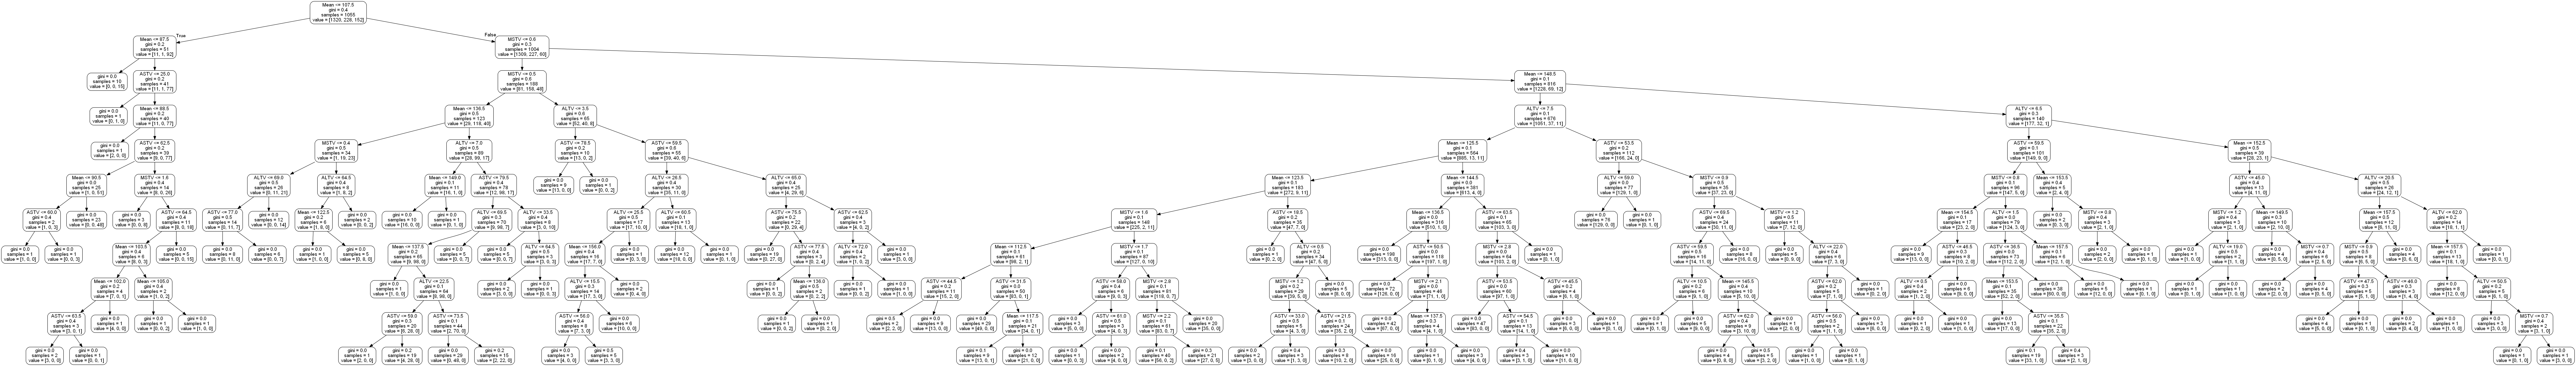

In [27]:
#Build the tree of the model with four most important variables

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# extract the feature names
sele = selected3.drop(['NSP'], axis = 1)
feature_names = [i for i in sele.columns]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

from IPython.display import Image 
Image(filename = 'tree.png')

0.8615023474178404
Variable: MSTV                 Importance: 0.68
Variable: FM                   Importance: 0.25
Variable: Tendency_left_asymmetric Importance: 0.03
Variable: Tendency_symmetric   Importance: 0.02
Variable: Tendency_right_asymmetric Importance: 0.01
The precision recall, F1 score and support for each class
              precision    recall  f1-score   support

           1      0.907     0.958     0.932       336
           2      0.732     0.492     0.588        61
           3      0.500     0.517     0.508        29

    accuracy                          0.862       426
   macro avg      0.713     0.656     0.676       426
weighted avg      0.854     0.862     0.854       426



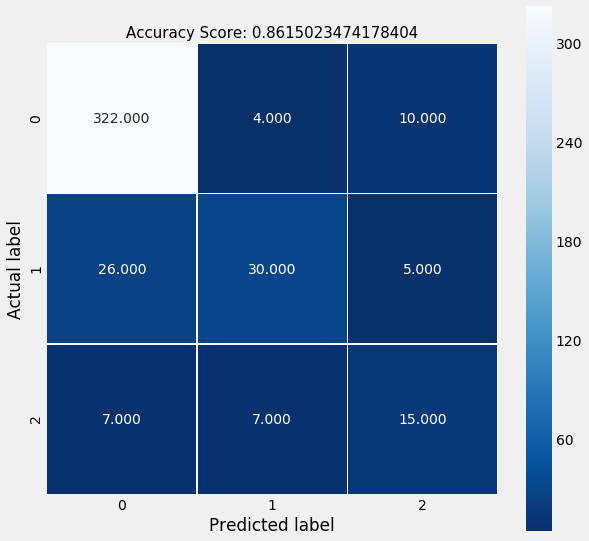

In [28]:
#Build model with features selected by logisticregressionclassifier
sc,cm,tree,imp,y_predict,y_pred_quant,y_pred_bin,X_train, X_test, y_train, y_test = random_forest(lrselected,'NSP',depth = 10, estimators = 1000)
#print(sc)
#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(sc)
plt.title(all_sample_title, size = 15);
# Print the precision and recall, among other metrics
print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))

0.960093896713615
Variable: ASTV                 Importance: 0.19
Variable: ALTV                 Importance: 0.17
Variable: MSTV                 Importance: 0.16
Variable: Mean                 Importance: 0.15
Variable: Mode                 Importance: 0.08
Variable: MLTV                 Importance: 0.07
Variable: Median               Importance: 0.07
Variable: AC                   Importance: 0.06
Variable: DP                   Importance: 0.06
The precision recall, F1 score and support for each class
              precision    recall  f1-score   support

           1      0.973     0.979     0.976       336
           2      0.912     0.852     0.881        61
           3      0.903     0.966     0.933        29

    accuracy                          0.960       426
   macro avg      0.930     0.932     0.930       426
weighted avg      0.960     0.960     0.960       426



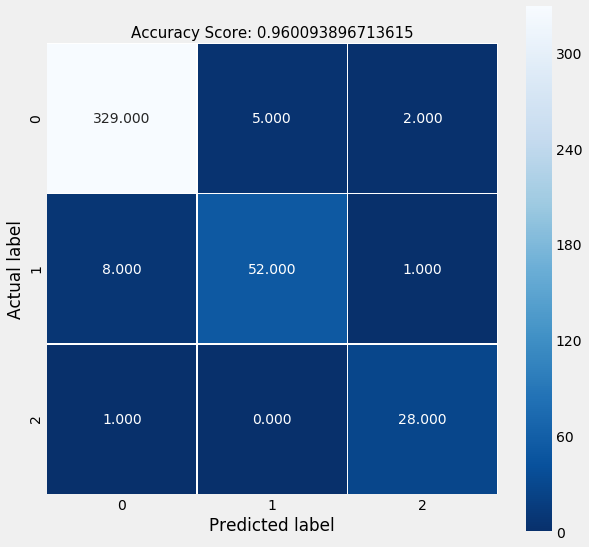

In [29]:
sc,cm,tree,imp,y_predict,y_pred_quant,y_pred_bin,X_train, X_test, y_train, y_test = random_forest(selected2,'NSP',depth = 10, estimators = 1000)
#print(sc)
#Create the confusion matrics
cm = metrics.confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(sc)
plt.title(all_sample_title, size = 15);
# Print the precision and recall, among other metrics
print("The precision recall, F1 score and support for each class")
print(metrics.classification_report(y_test, y_pred_bin, digits=3))